In [1]:
import os
import sys
import glob
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap, jit
# set cpu only
jax.config.update("jax_platform_name", "cpu")
# set 64-bit mode
# jax.config.update("jax_enable_x64", True)


from scipy import signal, interpolate, stats
# sys.path.append("/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE/")
import ddfa_node

from tqdm.auto import tqdm
import torch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

import warnings
from ddfa_node.utils.tde import takens_embedding
%load_ext autoreload
%autoreload 2

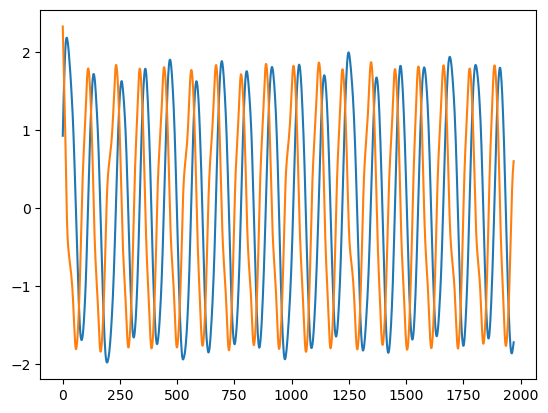

In [11]:
plt.plot(new_data[0, :, :])

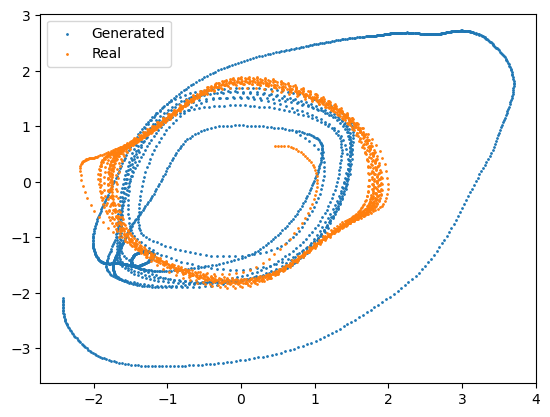

In [3]:
window_length = 30
polyorder = 3
data = jnp.load("outputs/VDP_oscillators.npy")[:, :, ::3]
data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3])


# Define the convolution function for a single time series
def convolve_1d(x):
    return jnp.convolve(x, jnp.ones((window_length,))/window_length, mode='valid')

# Vectorize over features
convolve_features = vmap(convolve_1d, in_axes=1, out_axes=1)
# Vectorize over trials
convolve_trials = vmap(convolve_features, in_axes=0, out_axes=0)

# Apply convolution to all trials and features at once
new_data = convolve_trials(data)

k, τ = 5, 26
data_tde = takens_embedding(new_data, k, τ)

data_gen = jnp.load("outputs/gen_vdp_data.npy")
trial, feat = 5, 0
t_steps_data = new_data.shape[1]
plt.scatter(data_gen[trial, :t_steps_data, feat], data_gen[trial, :t_steps_data, feat+1], s=1, label="Generated")
plt.scatter(data_tde[trial, :, feat], data_tde[trial, :, feat+1], s=1, label="Real")
plt.legend()

In [11]:
data_gen.shape

(100, 12000, 4)

In [2]:
@jax.jit
def weighted_multivariate_regression_with_bias(X, Y, W):
    """
    Fits a weighted multivariate regression model with an intercept and computes covariance errors.
    
    Parameters:
        X (jax.numpy.ndarray): Design matrix of shape (n_samples, n_features)
        Y (jax.numpy.ndarray): Output matrix of shape (n_samples, n_targets)
        W (jax.numpy.ndarray): Weight vector of shape (n_samples,)
    """
    # Add a column of ones to X for the intercept term
    X_aug = jnp.hstack([jnp.ones((X.shape[0], 1)), X])
    
    # If W is a vector, convert it to a diagonal matrix
    if W.ndim == 1:
        W = jnp.diag(W)
    
    # Compute the weighted regression coefficients
    XT_W_X = X_aug.T @ W @ X_aug
    XT_W_Y = X_aug.T @ W @ Y
    
    # Solve for coefficients
    coefficients = jnp.linalg.solve(XT_W_X, XT_W_Y)
    
    # Compute residuals
    residuals = Y - X_aug @ coefficients

    # Compute the covariance matrix of residuals
    n_samples = X_aug.shape[0]
    n_features = X_aug.shape[1]  # includes bias term
    
    # Modified covariance calculation
    covariance = jnp.linalg.inv(XT_W_X)
    
    # Standard error of the coefficients (including bias)
    std_errors = jnp.sqrt(jnp.diag(covariance))
    
    return {
        "coefficients": coefficients,  # shape: (n_features + 1, n_targets)
        "covariance": covariance,      # shape: (n_features + 1, n_features + 1)
        "std_errors": std_errors,      # shape: (n_features + 1,)
    }

In [3]:
key = jax.random.PRNGKey(0)
key_X, key_Y = jax.random.split(key, 2)
X = jax.random.normal(key_X, (100, 6))  # 100 samples, 6 features
Y = jax.random.normal(key_Y, (100, 6))  # 100 samples, 6 outputs
weights = jnp.exp(-jnp.arange(100) * 0.1)  # exponentially decreasing weights

result = weighted_multivariate_regression_with_bias(X, Y, weights)

In [2]:
def generate_synthetic_data(
    n_samples=1000,
    n_features=6,
    n_targets=6,
    true_coefficients=None,
    noise_std=0.1,
    seed=0
):
    """
    Generate synthetic data with known coefficients and noise level.
    
    Returns:
        X, Y, true_coefficients, weights
    """
    key = jax.random.PRNGKey(seed)
    key_coefs, key_X, key_noise, key_weights = jax.random.split(key, 4)
    
    # Generate features
    X = jax.random.normal(key_X, (n_samples, n_features))
    
    # Generate or use provided true coefficients (including bias)
    if true_coefficients is None:
        # true_coefficients = jnp.array([
        #     [-2.0, 2.0],  # bias terms
        #     [0.5, -0.5], # feature 1
        #     [-1.0, 3.0], # feature 2
        #     [2.0, -2.0], # feature 3
        # ])
        true_coefficients = jax.random.normal(key_coefs, (n_features + 1, n_targets))
    # Generate clean outputs
    X_aug = jnp.hstack([jnp.ones((n_samples, 1)), X])
    Y_clean = X_aug @ true_coefficients
    
    # Add noise
    noise = jax.random.normal(key_noise, Y_clean.shape) * noise_std
    Y = Y_clean + noise
    
    # Generate weights (exponentially decreasing)
    weights = jnp.exp(-jnp.arange(n_samples) * 0.01)
    
    return X, Y, true_coefficients, weights

def test_coefficient_recovery(
    n_samples=1000,
    n_features=3,
    n_targets=2,
    noise_std=0.1,
    confidence_level=0.95,
    seed=0
):
    """
    Test if the regression can recover known coefficients within confidence intervals.
    """
    # Generate synthetic data
    X, Y, true_coefficients, weights = generate_synthetic_data(
        n_samples=n_samples,
        n_features=n_features,
        n_targets=n_targets,
        noise_std=noise_std,
        seed=seed
    )
    
    # Fit model
    result = weighted_multivariate_regression_with_bias(X, Y, weights)
    
    # Get z-score for confidence level
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    
    # Compute confidence intervals
    ci_lower = result['coefficients'] - z_score * result['std_errors'][:, None]
    ci_upper = result['coefficients'] + z_score * result['std_errors'][:, None]
    
    # Check if true coefficients lie within confidence intervals
    within_ci = (ci_lower <= true_coefficients) & (true_coefficients <= ci_upper)
    coverage = jnp.mean(within_ci)
    
    # Compute relative errors
    rel_errors = jnp.abs((result['coefficients'] - true_coefficients) / true_coefficients)
    
    return {
        'coverage': coverage,
        'relative_errors': rel_errors,
        'estimated_coefficients': result['coefficients'],
        'true_coefficients': true_coefficients,
        'confidence_intervals': (ci_lower, ci_upper),
        'std_errors': result['std_errors']
    }

def run_monte_carlo_tests(
    n_trials=100,
    n_samples=1000,
    n_features=3,
    n_targets=2,
    noise_std=0.1,
    confidence_level=0.95
):
    """
    Run multiple trials to assess statistical properties of the estimator.
    """
    coverages = []
    rel_errors = []
    
    for i in tqdm(range(n_trials)):
        result = test_coefficient_recovery(
            n_samples=n_samples,
            n_features=n_features,
            n_targets=n_targets,
            noise_std=noise_std,
            confidence_level=confidence_level,
            seed=i
        )
        coverages.append(result['coverage'])
        rel_errors.append(result['relative_errors'])
    
    coverages = jnp.array(coverages)
    rel_errors = jnp.array(rel_errors)
    
    return {
        'mean_coverage': jnp.mean(coverages),
        'std_coverage': jnp.std(coverages),
        'mean_rel_error': jnp.mean(rel_errors, axis=0),
        'std_rel_error': jnp.std(rel_errors, axis=0)
    }

def plot_test_results(test_result):
    """
    Plot the estimated vs true coefficients with confidence intervals.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot estimated vs true coefficients
    ax1.scatter(test_result['true_coefficients'].flatten(), 
               test_result['estimated_coefficients'].flatten())
    ax1.plot([test_result['true_coefficients'].min(), test_result['true_coefficients'].max()],
             [test_result['true_coefficients'].min(), test_result['true_coefficients'].max()],
             'r--')
    ax1.set_xlabel('True Coefficients')
    ax1.set_ylabel('Estimated Coefficients')
    ax1.set_title('Estimated vs True Coefficients')
    
    # Plot confidence intervals
    coef_indices = jnp.arange(len(test_result['true_coefficients'].flatten()))
    
    # Repeat std_errors for each target
    n_targets = test_result['estimated_coefficients'].shape[1]
    std_errors_repeated = jnp.repeat(test_result['std_errors'], n_targets)
    
    ax2.errorbar(coef_indices, 
                test_result['estimated_coefficients'].flatten(),
                yerr=std_errors_repeated * 1.96,  # Changed this line
                fmt='o',
                label='Estimated with 95% CI')
    ax2.scatter(coef_indices, 
               test_result['true_coefficients'].flatten(),
               color='red',
               label='True Values')
    ax2.set_xlabel('Coefficient Index')
    ax2.set_ylabel('Coefficient Value')
    ax2.set_title('Coefficients with Confidence Intervals')
    ax2.legend()
    
    plt.tight_layout()
    return fig

  0%|          | 0/100 [00:00<?, ?it/s]

Monte Carlo Results:
Mean Coverage: 1.000 ± 0.000

Mean Relative Errors:
[[0.02588607 0.0239251 ]
 [0.03097278 0.06812456]
 [0.01935178 0.03477027]
 [0.05881024 0.01911076]]


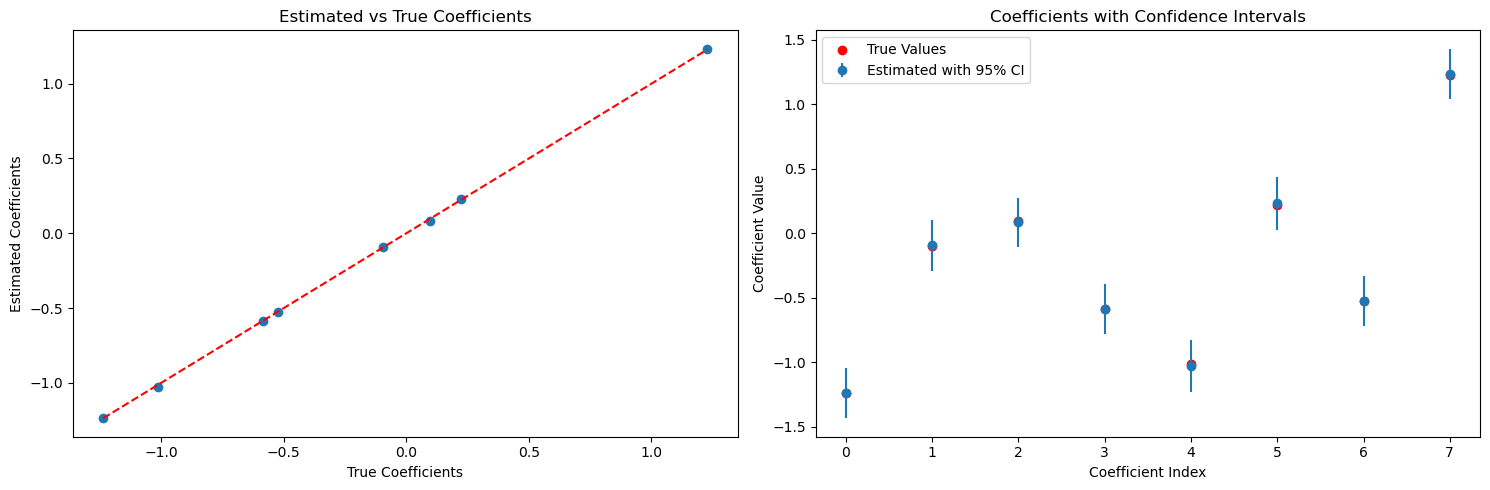

In [5]:
# Single test
test_result = test_coefficient_recovery(
    n_samples=1000,
    n_features=3,
    n_targets=2,
    noise_std=0.1
)

# Plot results
fig = plot_test_results(test_result)

# Monte Carlo simulation
mc_results = run_monte_carlo_tests(
    n_trials=100,
    n_samples=1000,
    n_features=3,
    n_targets=2,
    noise_std=0.1
)

print("Monte Carlo Results:")
print(f"Mean Coverage: {mc_results['mean_coverage']:.3f} ± {mc_results['std_coverage']:.3f}")
print("\nMean Relative Errors:")
print(mc_results['mean_rel_error'])

In [4]:
import jax
import jax.numpy as jnp
from ddfa_node.stability.new_floquet import analyze_eigenvalue_scaling

X, Y, true_coefficients, weights = generate_synthetic_data(
    n_samples=1000,
    n_features=3,
    n_targets=6,
    seed=0
)

print(X.shape, Y.shape, weights.shape, ks.shape)

ks = jnp.arange(2, 7)
results = analyze_eigenvalue_scaling(X, Y, weights, ks, n_repeats=500)

(1000, 3) (1000, 6) (1000,) (5,)


ValueError: All input arrays must have the same shape.

In [14]:
def create_random_subset_indices(key, n_samples, k, n_repeats):
    """
    Create random subset indices for splitting data into k groups.
    """
    subset_size = n_samples // k
    
    # Generate keys for each repeat
    keys = jax.random.split(key, n_repeats)
    
    @jax.vmap
    def get_permutations(key):
        # Generate random permutation of indices
        indices = jax.random.permutation(key, n_samples)
        # Reshape into k groups
        return indices[:subset_size * k].reshape(k, subset_size)
    
    return get_permutations(keys)

@jax.jit
def compute_subset_regression(X, Y, W, indices):
    """
    Compute regression on a subset of data specified by indices.
    
    Args:
        X: Full feature matrix (n_samples, n_features)
        Y: Full target matrix (n_samples, n_targets)
        W: Full weights vector (n_samples,)
        indices: Indices for subset selection (subset_size,)
    
    Returns:
        Regression results for the subset
    """
    X_subset = X[indices]
    Y_subset = Y[indices]
    W_subset = W[indices]
    
    return weighted_multivariate_regression_with_bias(X_subset, Y_subset, W_subset)

@jax.jit
def compute_multiple_subset_regressions(X, Y, W, all_indices):
    """
    Compute regressions for multiple subsets using vmap.
    
    Args:
        X: Full feature matrix
        Y: Full target matrix
        W: Full weights vector
        all_indices: Indices for all subsets (n_subsets, subset_size)
    
    Returns:
        Results for all subsets
    """
    return jax.vmap(lambda idx: compute_subset_regression(X, Y, W, idx))(all_indices)


def run_subset_analysis(X, Y, W, k, n_repeats, seed):
    """
    Run analysis for a single k value.
    """
    n_samples = X.shape[0]
    key = jax.random.PRNGKey(seed)
    
    # Generate all subset indices
    all_subset_indices = create_random_subset_indices(key, n_samples, k, n_repeats)
    
    # Reshape indices to (n_repeats * k, subset_size)
    flat_indices = all_subset_indices.reshape(-1, n_samples // k)
    
    # Compute regressions for all subsets
    all_results = compute_multiple_subset_regressions(X, Y, W, flat_indices)
    
    # Reshape results back to (n_repeats, k)
    return {
        'coefficients': all_results['coefficients'].reshape(n_repeats, k, -1, Y.shape[1]),
        'std_errors': all_results['std_errors'].reshape(n_repeats, k, -1),
        'subset_indices': all_subset_indices
    }

# Now let's run the analysis for multiple k values
def run_multiple_k_analysis(X, Y, W, ks, n_repeats=100):
    """
    Run analysis for multiple k values.
    """
    results = []
    for i, k in enumerate(ks):
        result = run_subset_analysis(X, Y, W, k, n_repeats, i)
        results.append(result)
    return results

# Example usage:
key = jax.random.PRNGKey(0)
X, Y, true_coefficients, weights = generate_synthetic_data(
    n_samples=1000,
    n_features=3,
    n_targets=2,
    seed=0
)

def analyze_subset_results(results, true_coefficients=None):
    """
    Analyze the results from repeated subset regressions.
    
    Args:
        results: Output from run_repeated_subset_regressions
        true_coefficients: Optional true coefficients for comparison
    """
    coefficients = results['coefficients']  # shape: (n_repeats, k, n_features+1, n_targets)
    std_errors = results['std_errors']      # shape: (n_repeats, k, n_features+1)
    
    # Compute mean and std across all repeats and subsets
    mean_coef = jnp.mean(coefficients, axis=(0, 1))  # shape: (n_features+1, n_targets)
    std_coef = jnp.std(coefficients, axis=(0, 1))    # shape: (n_features+1, n_targets)
    mean_stderr = jnp.mean(std_errors, axis=(0, 1))  # shape: (n_features+1)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot coefficient distributions for each target
    n_targets = mean_coef.shape[1]
    coef_indices = jnp.arange(mean_coef.shape[0])
    
    for i in range(n_targets):
        ax1.errorbar(coef_indices + i*0.1, 
                    mean_coef[:, i], 
                    yerr=std_coef[:, i], 
                    fmt='o', 
                    label=f'Target {i+1}')
        
        if true_coefficients is not None:
            ax1.scatter(coef_indices + i*0.1, 
                       true_coefficients[:, i], 
                       color='red', 
                       marker='x',
                       label=f'True Values {i+1}' if i == 0 else None)
    
    ax1.set_xlabel('Coefficient Index')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Mean Coefficients Across Subsets')
    ax1.legend()
    
    # Plot standard error distributions
    ax2.boxplot([std_errors[:,:,i].flatten() for i in range(std_errors.shape[2])])
    ax2.set_xlabel('Coefficient Index')
    ax2.set_ylabel('Standard Error')
    ax2.set_title('Standard Error Distributions')
    
    plt.tight_layout()
    return fig



In [35]:
from ddfa_node.stability.new_floquet import analyze_eigenvalue_scaling, run_multiple_k_analysis
seed = 0
X, Y, true_coefficients, weights = generate_synthetic_data(
    n_samples=50000,
    n_features=36,
    n_targets=36,
    seed=seed
)

ks = jnp.array([2, 3, 4, 5, 6])
print(X.shape, Y.shape, weights.shape, ks.shape)
# results = analyze_eigenvalue_scaling(results, ks)
results = run_multiple_k_analysis(X, Y, weights, ks, n_repeats=100)


(50000, 36) (50000, 36) (50000,) (5,)



Analyzing results for k=2

Analyzing results for k=3

Analyzing results for k=4

Analyzing results for k=5

Analyzing results for k=6


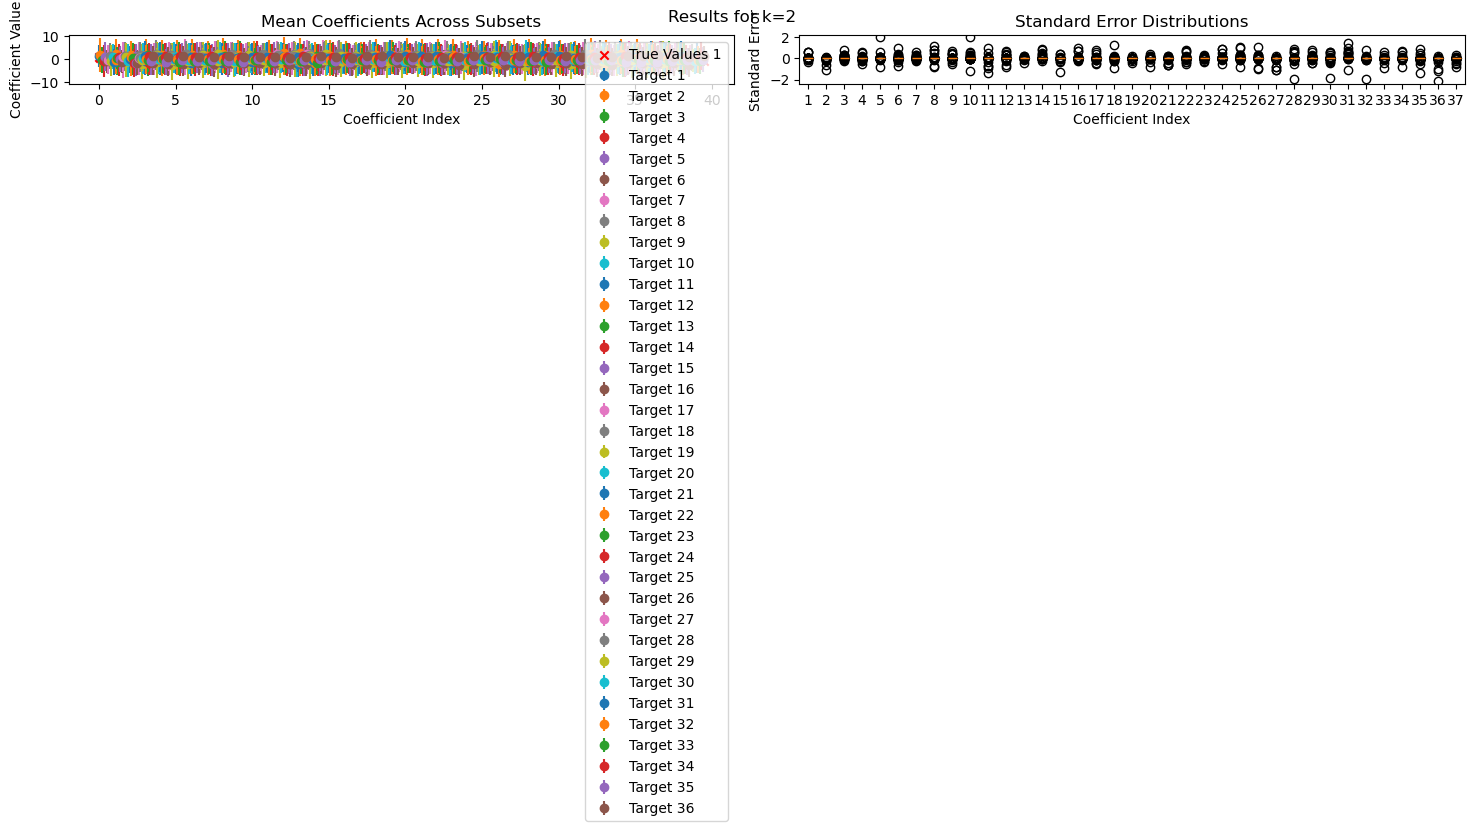

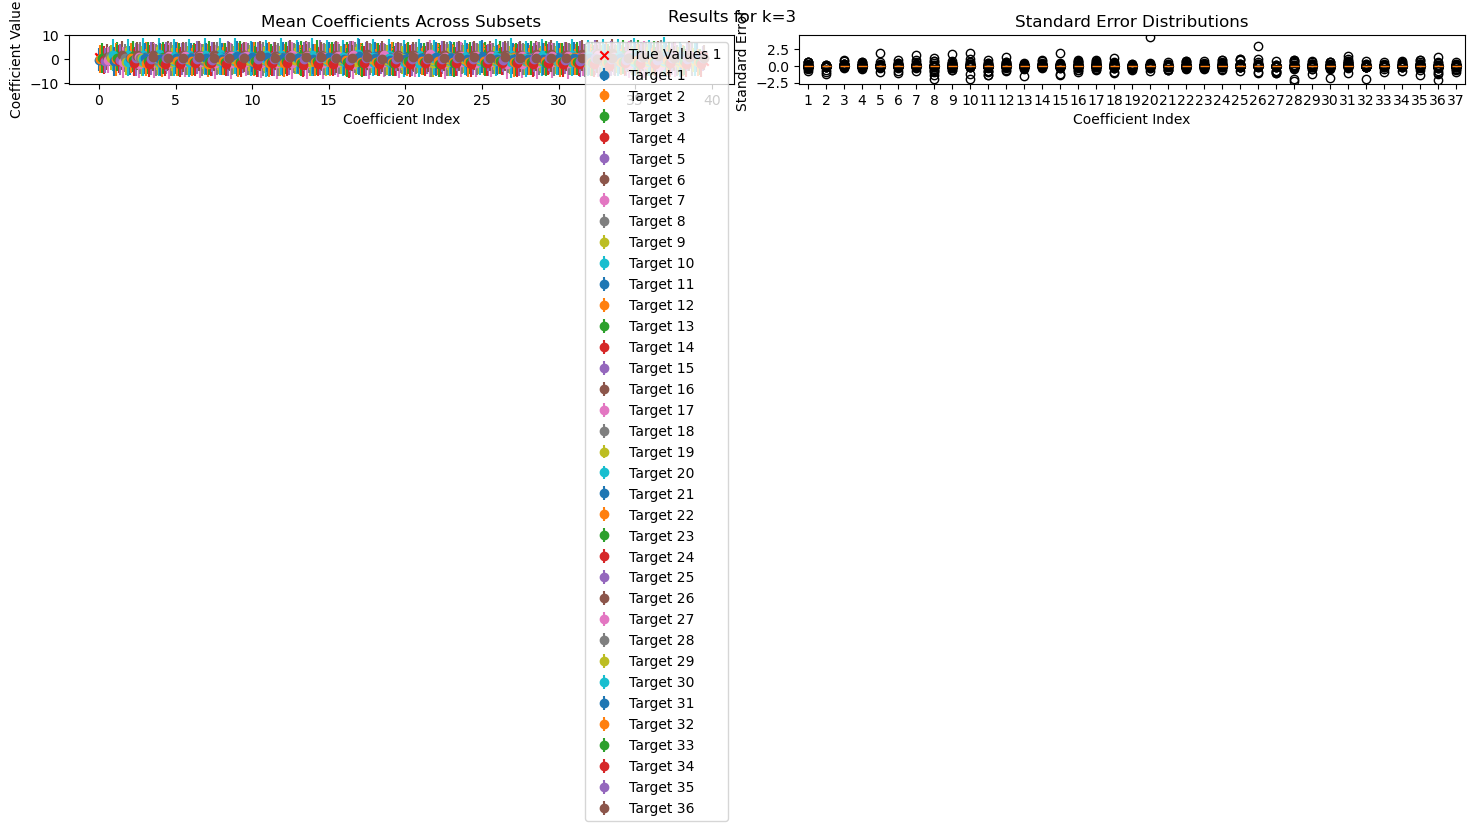

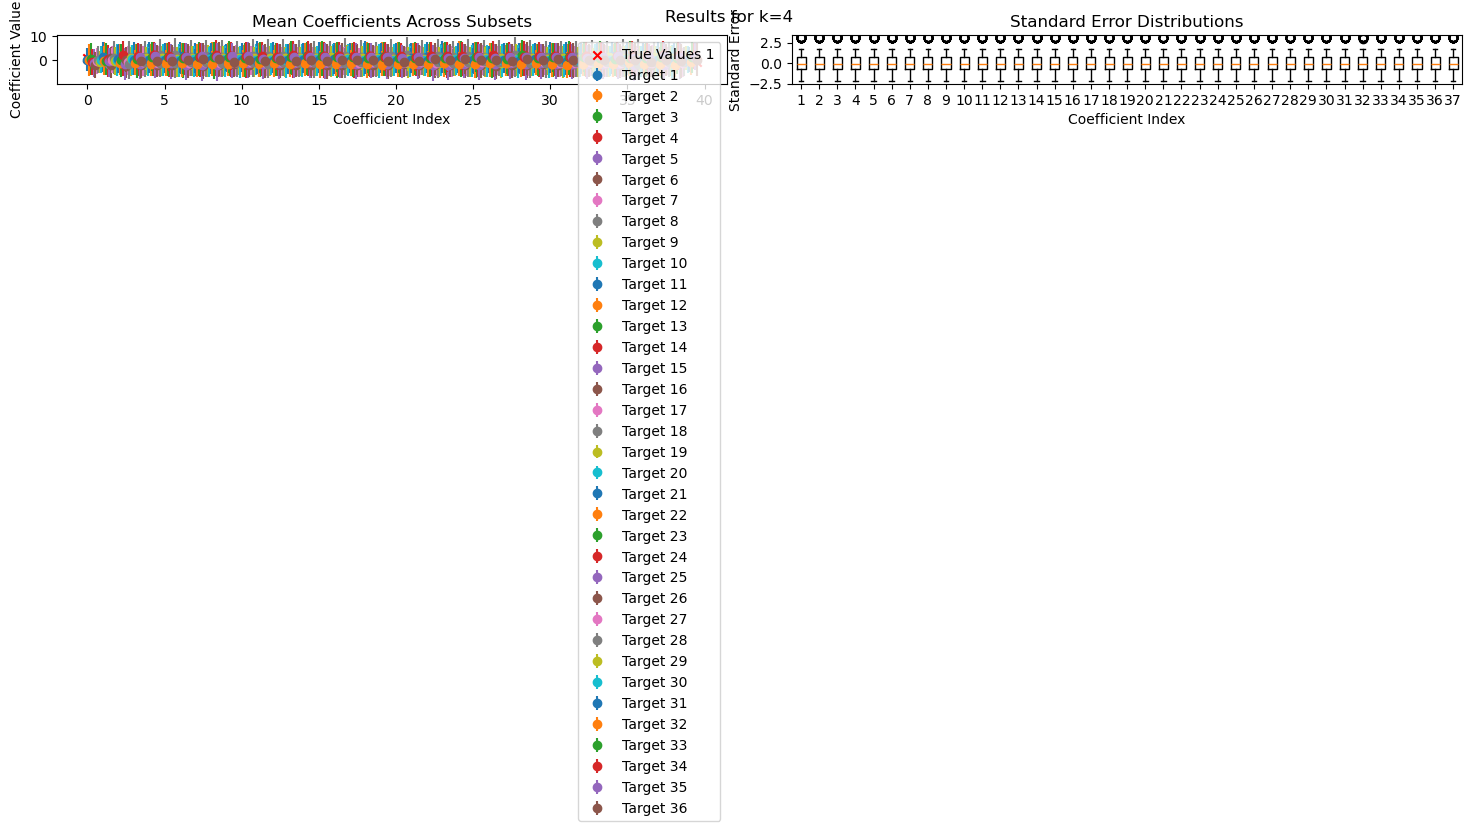

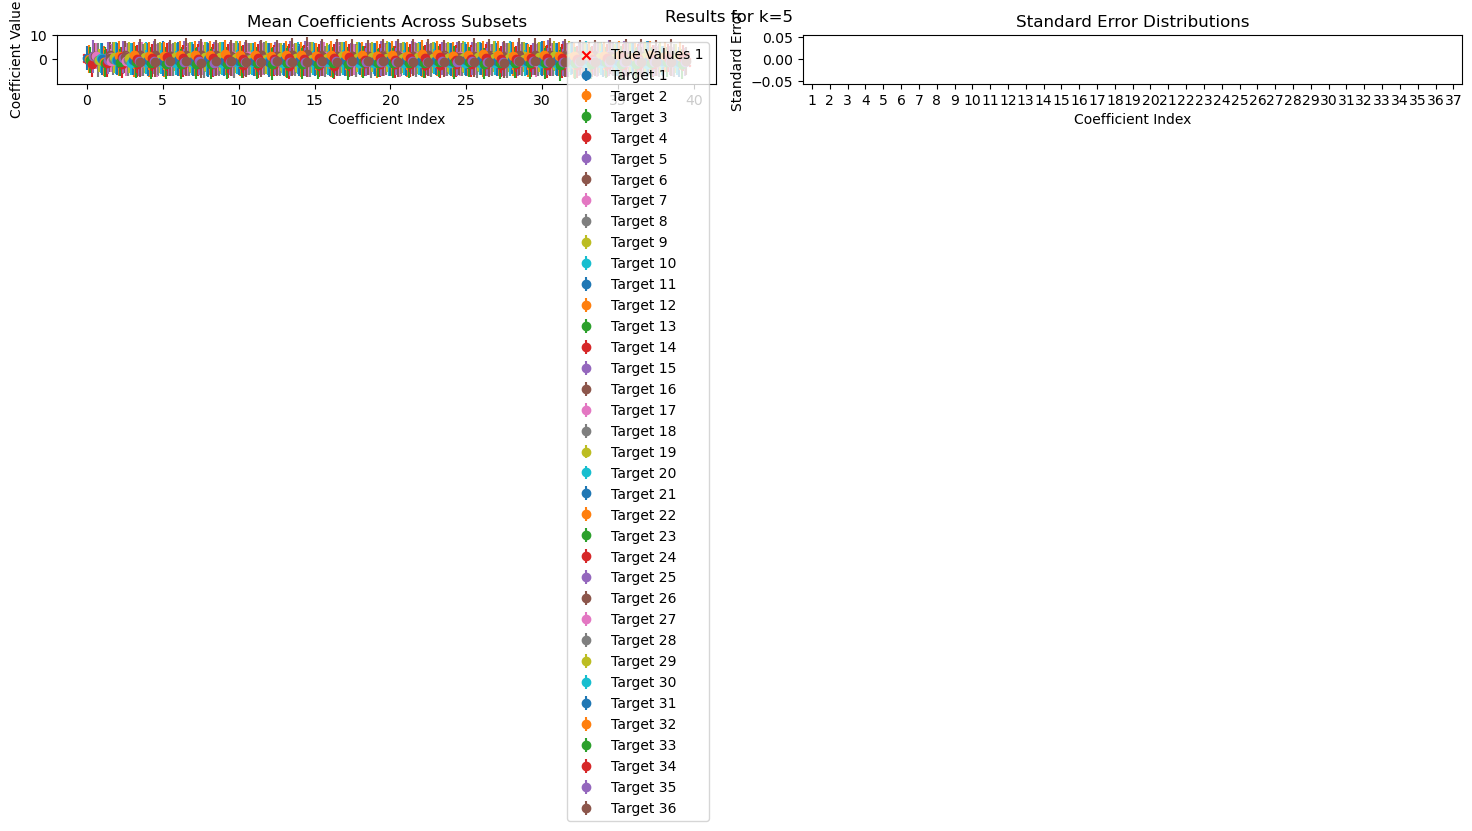

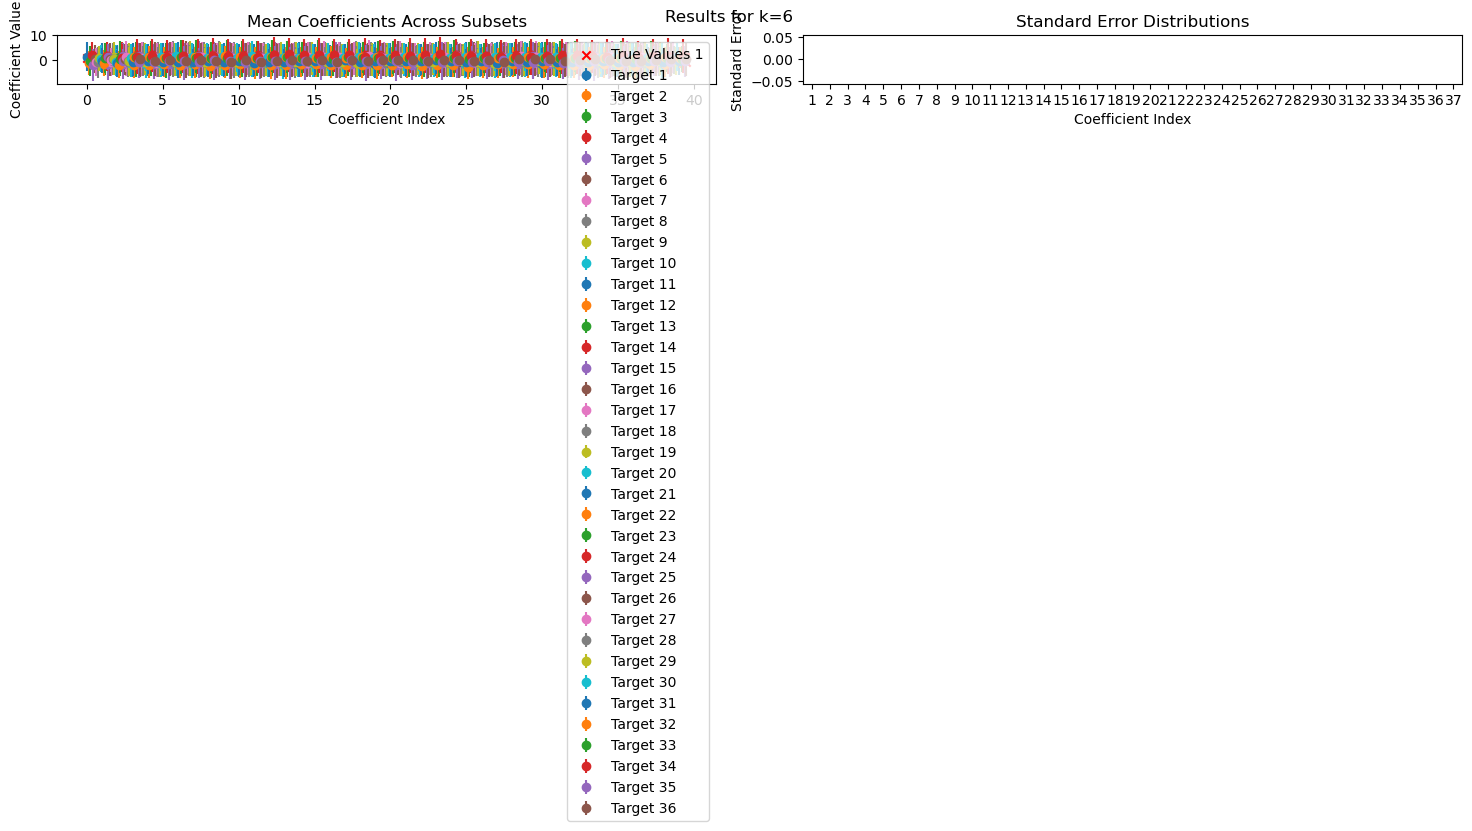

In [36]:

# Analyze results for each k
for k, result in zip(ks, results):
    print(f"\nAnalyzing results for k={k}")
    fig = analyze_subset_results(result, true_coefficients)
    plt.suptitle(f'Results for k={k}')

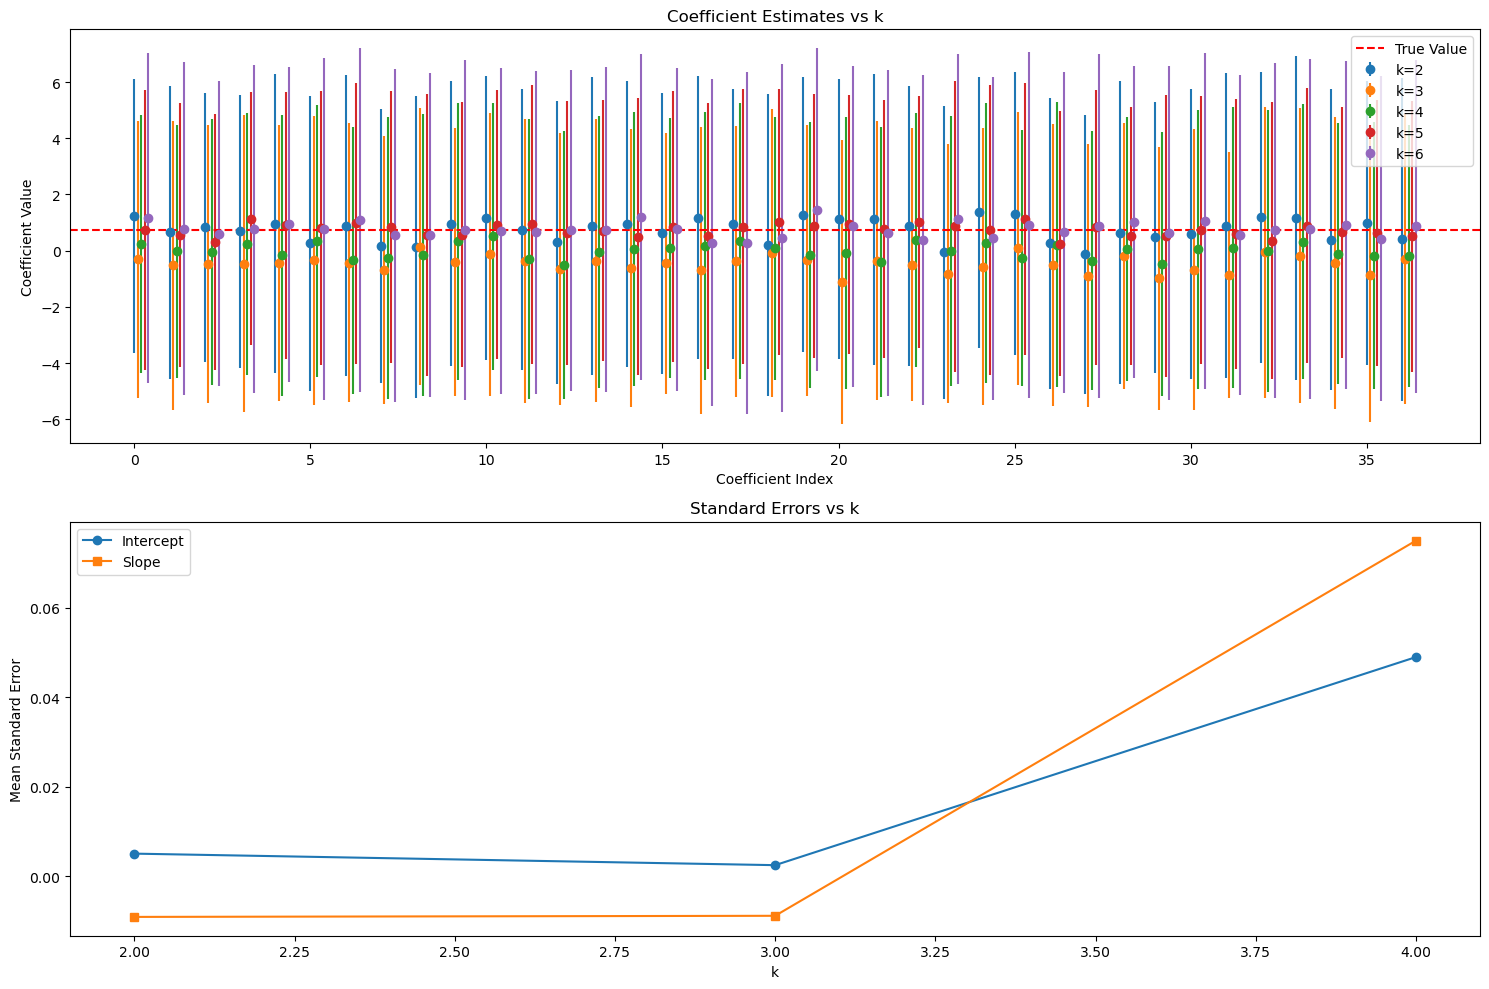

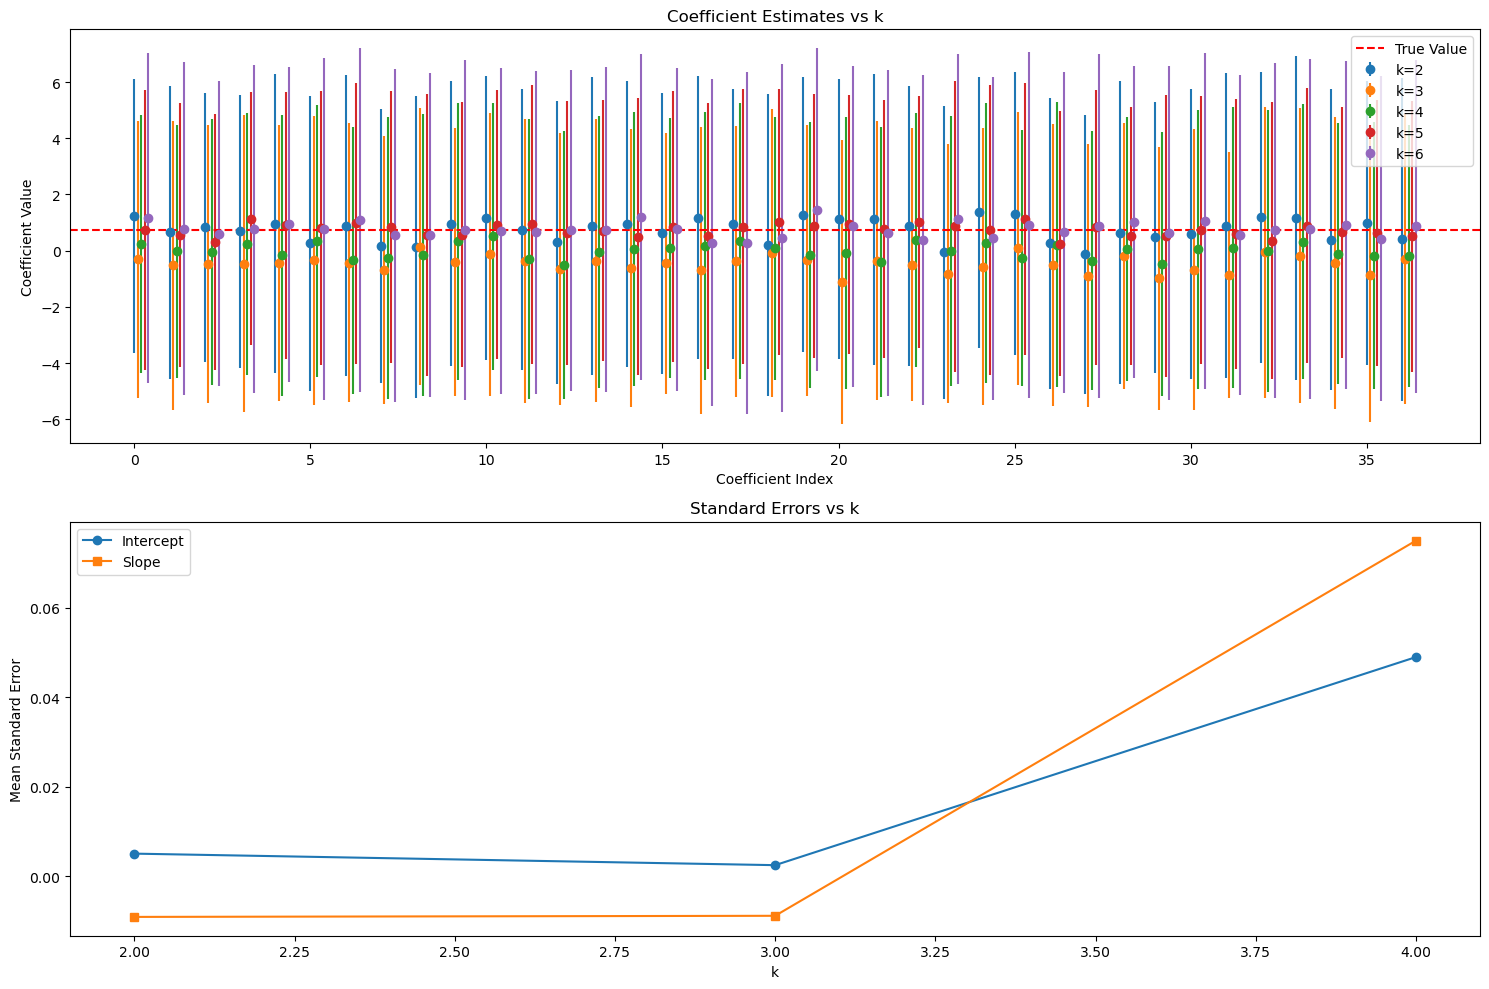

In [37]:
def compare_k_results(results, ks, true_coefficients=None):
    """
    Compare results across different k values.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    for i, (k, result) in enumerate(zip(ks, results)):
        # Get mean coefficients across repeats and subsets
        mean_coef = jnp.mean(result['coefficients'], axis=(0, 1))
        std_coef = jnp.std(result['coefficients'], axis=(0, 1))
        
        # Plot with offset for visibility
        offset = i * 0.1
        axes[0].errorbar(jnp.arange(mean_coef.shape[0]) + offset, 
                        mean_coef[:, 0],  # first target
                        yerr=std_coef[:, 0],
                        fmt='o',
                        label=f'k={k}')
    
    if true_coefficients is not None:
        axes[0].axhline(y=true_coefficients[0, 0], color='r', linestyle='--', label='True Value')
    
    axes[0].set_xlabel('Coefficient Index')
    axes[0].set_ylabel('Coefficient Value')
    axes[0].set_title('Coefficient Estimates vs k')
    axes[0].legend()
    
    # Plot standard errors vs k
    mean_stderr = [jnp.mean(result['std_errors'], axis=(0, 1)) for result in results]
    axes[1].plot(ks, [stderr[0] for stderr in mean_stderr], 'o-', label='Intercept')
    axes[1].plot(ks, [stderr[1] for stderr in mean_stderr], 's-', label='Slope')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Mean Standard Error')
    axes[1].set_title('Standard Errors vs k')
    axes[1].legend()
    
    plt.tight_layout()
    return fig

compare_k_results(results, ks, true_coefficients)

In [54]:
[out['regression_results'][i]['coefficients'][0].real for i in range(len(out['regression_results']))]


[Array([-0.36377296], dtype=float32),
 Array([0.44207743], dtype=float32),
 Array([0.11919053], dtype=float32),
 Array([-0.05906541], dtype=float32),
 Array([1.4528065], dtype=float32),
 Array([2.2066257], dtype=float32),
 Array([0.33868715], dtype=float32),
 Array([-0.9245122], dtype=float32),
 Array([-0.00199733], dtype=float32),
 Array([-0.2131691], dtype=float32),
 Array([1.283576], dtype=float32),
 Array([3.5243404], dtype=float32),
 Array([1.791202], dtype=float32),
 Array([0.11100186], dtype=float32),
 Array([-2.4442859], dtype=float32),
 Array([0.06878383], dtype=float32),
 Array([-0.5989373], dtype=float32),
 Array([-0.6830275], dtype=float32),
 Array([0.29822928], dtype=float32),
 Array([-0.28312454], dtype=float32),
 Array([0.3635125], dtype=float32),
 Array([0.81247735], dtype=float32),
 Array([1.7502643], dtype=float32),
 Array([-0.0603353], dtype=float32),
 Array([0.02146398], dtype=float32),
 Array([-0.6935511], dtype=float32),
 Array([-0.88753414], dtype=float32),
 Arra

/mnt/Mouse_Face_Project/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/Mouse_Face_Project/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/tmp/ipykernel_1143809/62218417.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


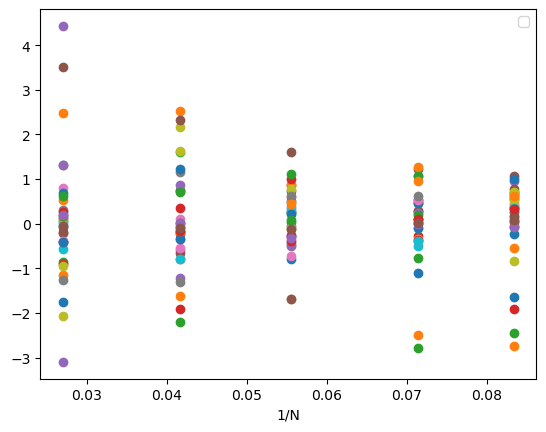

In [38]:
out = analyze_eigenvalue_scaling(results, ks)

# plot the results
for i in range(out['y_values'].shape[1]):
    plt.scatter(out['x_values'], out['y_values'][:, i])

plt.xlabel('1/N')
plt.legend()

In [ ]:




def sample_floquet_multipliers(HC_CellArray, nSegments=101, nCovReps=500, phaser_feats=None, splits=jnp.arange(2, 10), nReplicates=10, usePCA=False, height=0.85, distance=80, vecs=False):
    trim_cycles = 1
    feats = HC_CellArray[0].shape[1]
    if phaser_feats is None:
        phaser_feats = feats
    nSplits = len(splits)
    lim = len(HC_CellArray)
    
    allPhis = []
    
    # Initialize arrays with JAX
    allEigenvals = jnp.full((lim, nSplits, jnp.max(splits), nReplicates, nSegments, nCovReps, feats), jnp.inf + 1j*jnp.inf, dtype=jnp.complex64)
    if vecs:
        allEigenvecs = jnp.full((lim, nSplits, jnp.max(splits), nReplicates, nSegments, nCovReps, feats, feats), jnp.inf + 1j*jnp.inf, dtype=jnp.complex64)
    else:
        allEigenvecs = []
    allRs = jnp.full((lim, nSplits, jnp.max(splits), nReplicates, nSegments, feats), jnp.nan)
    Ns = jnp.zeros(lim)

    def process_trial(a):
        raw = jnp.transpose(HC_CellArray[a])
        allsigs, phi2 = get_phased_signals(raw, phaser_feats, trim_cycles, nSegments, height, distance)
        N = allsigs.shape[0]
        Ns = Ns.at[a].set(N)

        def process_split(split_idx):
            split = splits[split_idx]
            
            def process_subset(split_idx2):
                def process_replicate(rep_idx):
                    # Use JAX random instead of numpy random
                    key = jax.random.PRNGKey(rep_idx)
                    indices = jax.random.permutation(key, allsigs.shape[0])
                    data = jnp.array_split(allsigs[indices], split)

                    def process_phase(phase_idx):
                        s = data[split_idx2][:, :, phase_idx]
                        
                        # Use weighted regression instead of get_eigenstuff
                        s1 = s[:-1]
                        s2 = s[1:]
                        W = jnp.ones(s1.shape[0])
                        
                        result = weighted_multivariate_regression_with_bias(s1, s2, W)
                        eigenvals = get_eigenvalues(result["coefficients"])
                        
                        return eigenvals, result["std_errors"]

                    return jax.vmap(process_phase)(jnp.arange(nSegments))

                return jax.vmap(process_replicate)(jnp.arange(nReplicates))

            return jax.vmap(process_subset)(jnp.arange(split))

        return jax.vmap(process_split)(jnp.arange(nSplits)), Ns, phi2

    # Vectorize over trials
    results = jax.vmap(process_trial)(jnp.arange(lim))
    
    return results[0], allEigenvecs, results[1], allPhis, results[2]

@jax.jit 
def backtrace_multipliers(splits, eigVals, Ns, subject=0, nPoints=5, phase=50, eig=0, plot=False):
    splits = splits[:nPoints]
    b = jnp.real(eigVals[subject, :nPoints, :, :, phase, :, eig]).squeeze()
    
    X = 1/Ns[subject]/splits
    
    def process_split(idx):
        c = b[idx, :splits[idx]]
        return jnp.mean(c), jnp.std(c)
    
    means_stds = jax.vmap(process_split)(jnp.arange(len(splits)))
    mean = means_stds[0]
    std = means_stds[1]
    
    # Use weighted regression
    W = 1.0 / std
    result = weighted_multivariate_regression_with_bias(
        X[:, None],
        mean[:, None], 
        W
    )
    
    return result["coefficients"][-1], jnp.sqrt(result["covariance"][-1, -1])

@jax.jit
def backtrace_multipliers_all(allEigenvals, Ns, splits, nPoints=4):
    n_subjects, _, _, _, n_phases, _, n_eigs = allEigenvals.shape
    
    def process_subject(subject):
        def process_phase(phase):
            def process_eig(eig):
                return backtrace_multipliers(splits, allEigenvals, Ns, 
                                          subject=subject, nPoints=nPoints,
                                          phase=phase, eig=eig, plot=False)
            return jax.vmap(process_eig)(jnp.arange(n_eigs))
        return jax.vmap(process_phase)(jnp.arange(n_phases))
    
    results = jax.vmap(process_subject)(jnp.arange(n_subjects))
    
    return jnp.array([r[0] for r in results]), jnp.array([r[1] for r in results])

In [ ]:
def sample_floquet_multipliers(HC_CellArray, nSegments=100, nCovReps=10, splits=jnp.array([2,3,4,5]), nReplicates=10):
    """
    Compute Floquet multipliers by subsampling cycles and extrapolating to infinite sample size.
    
    Args:
        HC_CellArray: List of arrays, each of shape (n_timesteps, n_features)
        nSegments: Number of phase segments to divide each cycle into
        nCovReps: Number of random subset repetitions per split
        splits: Array of different numbers of splits to try
        nReplicates: Number of times to repeat the full analysis
    
    Returns:
        eigenvals: Array of shape (n_trials, n_splits, max_split, n_replicates, n_segments, n_covreps, n_features)
        eigenvecs: Array of same shape as eigenvals but last dim is (n_features, n_features)
        Ns: Array of shape (n_trials) containing number of cycles for each trial
        phis: List of phase values for each trial
        phase_data: List of phased signals for each trial
    """
    lim = len(HC_CellArray)
    n_features = HC_CellArray[0].shape[1]
    max_split = int(splits.max())
    
    # Initialize output arrays
    allEigenvals = np.zeros((lim, len(splits), max_split, nReplicates, nSegments, nCovReps, n_features))
    allEigenvecs = np.zeros((lim, len(splits), max_split, nReplicates, nSegments, nCovReps, n_features, n_features))
    allPhis = []
    Ns = np.zeros(lim)
    phase_data = []

    # JIT compile the core computation functions
    @jax.jit
    def compute_regression(X, Y):
        """Compute regression coefficients and eigendecomposition"""
        reg_result = weighted_multivariate_regression_with_bias(X, Y, jnp.ones(X.shape[0]))
        coeffs = reg_result["coefficients"][1:] # Remove bias term
        coeffs = coeffs.reshape(n_features, n_features)
        # Compute eigenvalues and eigenvectors on CPU
        with jax.default_device(jax.devices("cpu")[0]):
            eigenvals, eigenvecs = jnp.linalg.eig(coeffs)
        return eigenvals, eigenvecs

    # This function intentionally not JIT compiled since get_phased_signals may be complex
    for a in tqdm(range(lim)):
        try:
            # Get phased signals
            raw = HC_CellArray[a].T
            allsigs, phi2 = get_phased_signals(raw, nSegments=nSegments)
            allPhis.append(phi2)
            Ns[a] = allsigs.shape[0]
            phase_data.append(allsigs)
            
            # For each split size
            for split_idx, split in enumerate(splits):
                # For each subdivision of that split
                for split_idx2 in range(split):
                    # For each replicate
                    for rep_idx in range(nReplicates):
                        # Randomly split data
                        data = np.array_split(np.random.permutation(allsigs), split)
                        
                        # For each phase
                        for phase_idx in range(nSegments):
                            s = data[split_idx2][:, :, phase_idx]
                            
                            # Get current and next cycle data
                            X = s[:-1]
                            Y = s[1:]
                            
                            # Compute eigendecomposition for multiple random subsets
                            for cov_idx in range(nCovReps):
                                subset_size = X.shape[0] // 2
                                idx = np.random.choice(X.shape[0], subset_size, replace=False)
                                eigenvals, eigenvecs = compute_regression(X[idx], Y[idx])
                                
                                allEigenvals[a, split_idx, split_idx2, rep_idx, phase_idx, cov_idx] = eigenvals
                                allEigenvecs[a, split_idx, split_idx2, rep_idx, phase_idx, cov_idx] = eigenvecs
                                
        except Exception as e:
            print(f"Trial {a} failed: {str(e)}")
            continue

    return allEigenvals, allEigenvecs, Ns, allPhis, phase_data

def backtrace_multipliers(splits, eigVals, Ns, subject=0, nPoints=5, phase=50, eig=0, plot=True):
    """
    Compute infinite-N limit of Floquet multipliers through linear regression.
    
    Args:
        splits: Array of split sizes used
        eigVals: Array of eigenvalues from sample_floquet_multipliers
        Ns: Array of cycle counts for each trial
        subject: Which trial to analyze
        nPoints: How many split sizes to use
        phase: Which phase to analyze
        eig: Which eigenvalue ordinal to analyze
        plot: Whether to generate diagnostic plot
        
    Returns:
        intercept: Estimated infinite-N Floquet multiplier
        stderr: Standard error of estimate
    """
    splits = splits[:nPoints]
    b = jnp.real(eigVals[subject, :nPoints, :, :, phase, :, eig]).squeeze()
    
    # Compute means and standard errors across replicates
    mean = jnp.mean(b, axis=(1,2))
    std = jnp.std(b, axis=(1,2)) / jnp.sqrt(b.shape[1] * b.shape[2])
    
    # X values are 1/N for each split
    X = 1/(Ns[subject] * splits)
    
    # Perform weighted regression
    reg_result = weighted_multivariate_regression_with_bias(
        X[:, None],
        mean[:, None], 
        1/std**2
    )
    
    intercept = float(reg_result["coefficients"][-1])
    stderr = float(reg_result["std_errors"][-1])
    
    if plot:
        plt.figure()
        plt.errorbar(X, mean, std, fmt='o', capsize=5)
        x_fit = jnp.linspace(0, X.max(), 100)
        y_fit = reg_result["coefficients"][0] + reg_result["coefficients"][1] * x_fit
        plt.plot(x_fit, y_fit, 'k--')
        plt.scatter(0, intercept, c='r', zorder=10)
        plt.errorbar(0, intercept, stderr, fmt='o', c='r', capsize=5)
        plt.xlabel("1/N")
        plt.ylabel("Floquet Multiplier")
        plt.tight_layout()
        
    return intercept, stderr
